# Анализ А/Б теста мобильного приложения Cookie Cats

Данные с сайта kaggle.com - https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats

**About Dataset:**

`Context: ` This dataset includes A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

`Content: `The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

- `userid`: A unique number that identifies each player.
- `version`: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- `sum_gamerounds`: the number of game rounds played by the player during the first 14 days after install.
- `retention_1`: Did the player come back and play 1 day after installing?
- `retention_7`: Did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as st 
from statsmodels.stats.proportion import proportions_ztest

## Загрузка данных, предобработка таблицы и знакомство с данными. 

In [2]:
df = pd.read_csv('C:\\datasets\\cookie_cats.csv')

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.shape

(90189, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


In [7]:
df.userid.nunique()

90189

Итак, в нашей таблице находится информация о 90189 игроках. 

Всего столбцов 5:
- `userid` - айди пользователя
- `version` - контрольная группа
- `sum_gamerounds` - количество пройденных игровых раундов спустя 14 дней после установки игры 
- `retention_1` - удержание на первый день
- `retention_7` - удержание на седьмой день

Типы данных корректы.

Немного изменим названия столбцов для удобства. 

In [8]:
df = df.rename(columns={'userid':'user_id', 'version':'group','sum_gamerounds':'game_rounds'})

In [9]:
df.group.value_counts()

gate_40    45489
gate_30    44700
Name: group, dtype: int64

In [10]:
df.group = df.group.str.replace('gate_30', 'A')
df.group = df.group.str.replace('gate_40', 'B')

In [11]:
df.head()

,user_id,group,game_rounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


In [59]:
df.isna().sum()

user_id        0
group          0
game_rounds    0
retention_1    0
retention_7    0
dtype: int64

In [60]:
df.duplicated().sum()

0

Приступим к исследованию. 

In [12]:
df.groupby('group')['game_rounds'].agg(['sum', 'mean', 'median', 'max', 'std'])

,sum,mean,median,max,std
group,,,,,
A,2344795,52.456264,17.0,49854,256.716423
B,2333530,51.298776,16.0,2640,103.294416


In [13]:
df.game_rounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: game_rounds, dtype: float64

In [14]:
df.loc[df.game_rounds == 49854]

,user_id,group,game_rounds,retention_1,retention_7
57702,6390605,A,49854,False,True


In [15]:
df = df.drop(index=57702)

In [16]:
df.groupby('group')['game_rounds'].agg(['sum', 'mean', 'median', 'max', 'std'])

,sum,mean,median,max,std
group,,,,,
A,2294941,51.342111,17.0,2961,102.057598
B,2333530,51.298776,16.0,2640,103.294416


По пройденным раундов все достаточно ровно. 

Подробнее взглянем на показатели удержания.

In [17]:
group_a = df.query('group =="A"')
group_b = df.query('group =="B"')

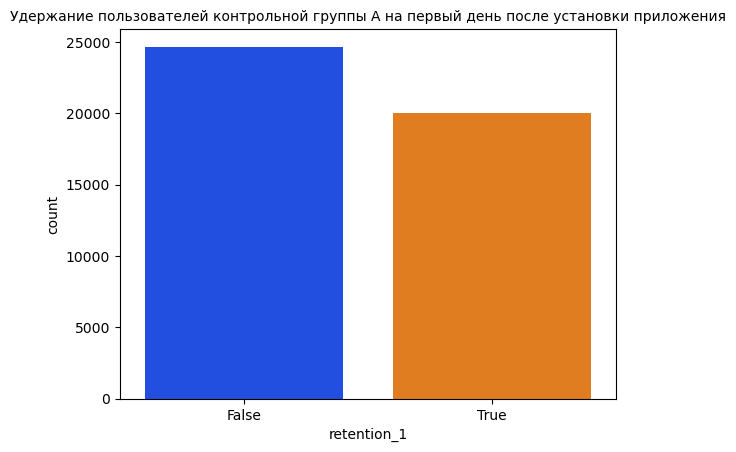

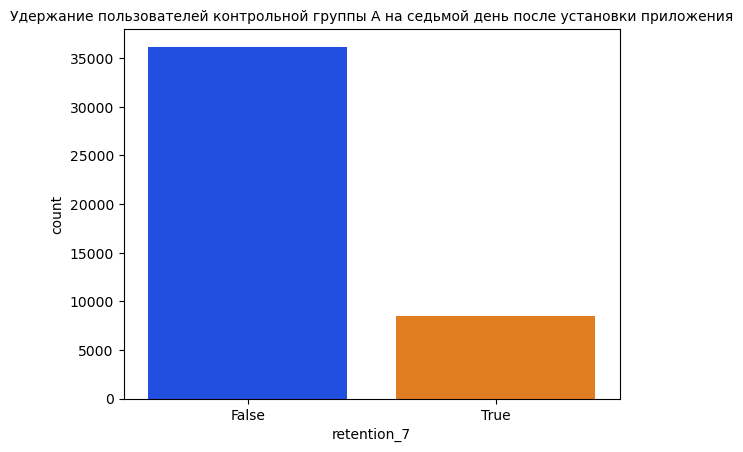

In [18]:
sns.countplot(x=group_a.retention_1, palette='bright')
plt.title('Удержание пользователей контрольной группы А на первый день после установки приложения', size=10)
plt.show();

sns.countplot(x=group_a.retention_7, palette='bright')
plt.title('Удержание пользователей контрольной группы А на седьмой день после установки приложения', size=10)
plt.show();

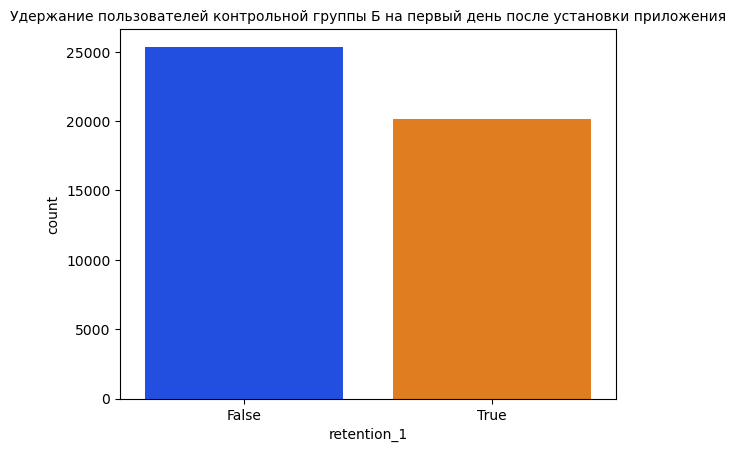

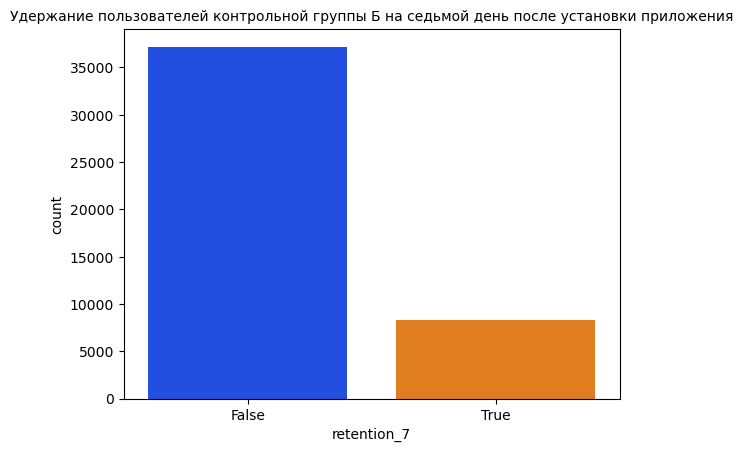

In [19]:
sns.countplot(x=group_b.retention_1, palette='bright')
plt.title('Удержание пользователей контрольной группы Б на первый день после установки приложения', size=10)
plt.show();

sns.countplot(x=group_b.retention_7, palette='bright')
plt.title('Удержание пользователей контрольной группы Б на седьмой день после установки приложения', size=10)
plt.show();

Результаты обеих групп на первый взгляд практически идентичны. 

## Анализ результатов А/Б тестирования. 

Сформулируем гипотезы о различии пройденных игровых раундов после введенных в игру изменений.

- Нулевая гипотеза: количество пройденных раундов одинаково
- Альтернативная: количество пройденных раундов различается 

In [20]:
#задаем уровень значимости
alpha = .05

results = st.ttest_ind(group_a.game_rounds, group_b.game_rounds, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.9494686215464458
Нет оснований отвергнуть нулевую гипотезу


Проверим насколько разница между группами в показателе удержания статистически значима c помощью пропорционного Z-теста. 

In [22]:
group_a.retention_1 = group_a.retention_1.map({True:1, False: 0})
group_a.retention_7 = group_a.retention_7.map({True:1, False: 0})

group_b.retention_1 = group_b.retention_1.map({True:1, False: 0})
group_b.retention_7 = group_b.retention_7.map({True:1, False: 0})

In [42]:
count_a_true = group_a[group_a['retention_1'] == 1].shape[0]
count_b_true = group_b[group_b['retention_1'] == 1].shape[0]
count_a_true7 = group_a[group_a['retention_7'] == 1].shape[0]
count_b_true7 = group_b[group_b['retention_7'] == 1].shape[0]

count_a = group_a.shape[0]
count_b = group_b.shape[0]

Сформулируем гипотезы:
- Нулевая: удержание обеих групп одинаково
- Альтернативная: есть различия в удержании

In [44]:
count = np.array([count_a_true, count_b_true])
nobs = np.array([count_a, count_b])

alpha = .05
stat, pvalue = proportions_ztest(count, nobs)

print('p_value: {}'.format(pvalue))

if pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p_value: 0.0739207603418346
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [46]:
count = np.array([count_a_true7, count_b_true7])
nobs = np.array([count_a, count_b])
alpha = .05
stat, pvalue = proportions_ztest(count, nobs)

print('p_value: {}'.format(pvalue))

if pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p_value: 0.0015917731773993442
Отвергаем нулевую гипотезу


In [57]:
perc_1a = round((count_a_true / count_a * 100), 2)
perc_7a = round((count_a_true7 / count_a *100), 2)

perc_1b = round((count_b_true / count_b * 100), 2)
perc_7b = round((count_b_true7 / count_b * 100), 2)

In [58]:
print(perc_1a, perc_7a)

print(perc_1b, perc_7b)

44.82 19.02
44.23 18.2


## Вывод 

В результате анализа проведенного А/Б теста мы выяснили, что: 
- нет статистически значимых отличий в количестве пройденных раундов между игроками подконтрольных групп;
- нет статистически значимой разницы между уровнем удержания подконтрольных групп на первый день;
- есть статистически значимая разница между уровнем удержания подконтрольных групп на седьмой день.

Учитывая вышесказанное и факт того, что на седьмой день показатели удержания в группе А выше группы В, считаю нецелесообразным перемещение врат (gate) на сороковой уровень вместо тридцатого. 